# **Task 1: Interest Point Detection, Feature Matching and Contour Detection**

### **Interest Point Detection with SIFT**

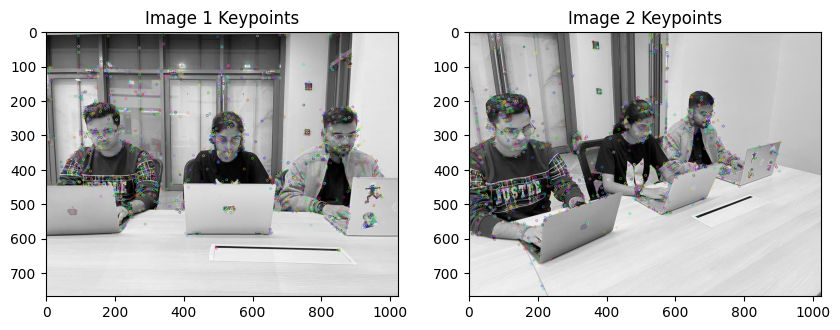

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Read images
img1 = cv2.imread('/content/image1.jpeg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('/content/image2.jpeg', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# Draw keypoints
img1_kp = cv2.drawKeypoints(img1, keypoints1, None)
img2_kp = cv2.drawKeypoints(img2, keypoints2, None)

plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(img1_kp), plt.title('Image 1 Keypoints')
plt.subplot(122), plt.imshow(img2_kp), plt.title('Image 2 Keypoints')
plt.show()

### **Feature Matching with ORB and BFMatcher**

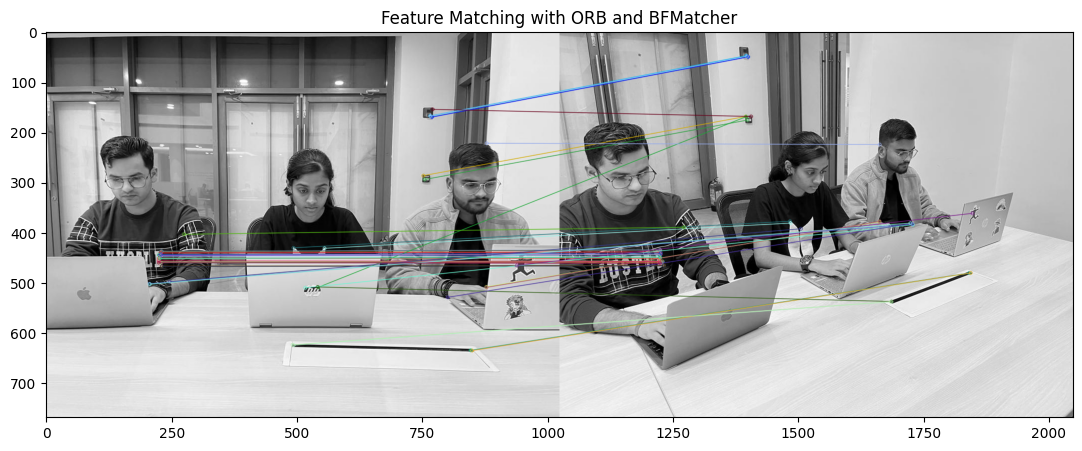

In [ ]:
# Initialize ORB detector
orb = cv2.ORB_create()

# Find keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw first 50 matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=2)

plt.figure(figsize=(15,5))
plt.imshow(img_matches)
plt.title('Feature Matching with ORB and BFMatcher')
plt.show()

###**Contour Detection with Custom Seeds**

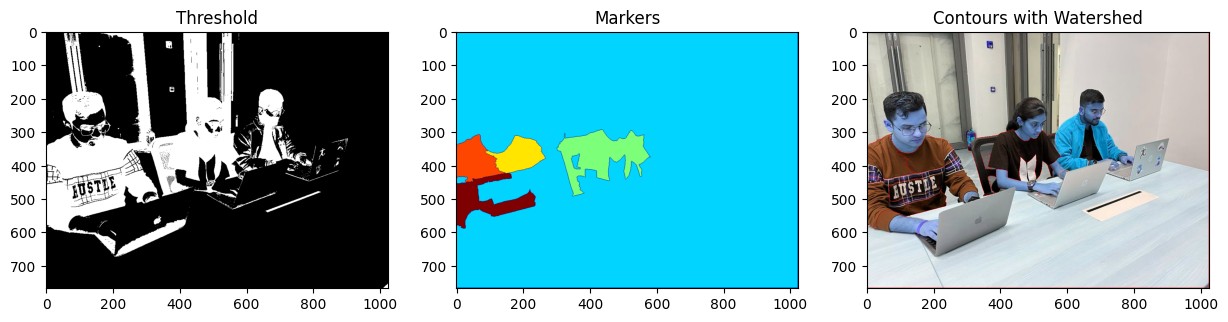

In [ ]:
# Read image
img = cv2.imread('/content/image2.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Mark the region of unknown with zero
markers[unknown == 255] = 0

# Apply watershed
markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,0]

# Display results
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(thresh, cmap='gray'), plt.title('Threshold')
plt.subplot(132), plt.imshow(markers, cmap='jet'), plt.title('Markers')
plt.subplot(133), plt.imshow(img), plt.title('Contours with Watershed')
plt.show()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import time
from torchvision import models

# Step 1: Define transformations and load dataset
transform = transforms.Compose([
    transforms.Resize(224),  # ResNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                        shuffle=False, num_workers=2)

# Step 2: Load pretrained models
def get_resnet(model_name):
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
    elif model_name == 'resnet34':
        model = models.resnet34(pretrained=True)

    # Modify the final layer for CIFAR-100 (100 classes)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 100)
    return model

# Step 3: Training function
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(trainset)
        epoch_acc = running_corrects.double() / len(trainset)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    return model

# Step 4: Evaluation function
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    inference_time = 0

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            start_time = time.time()
            outputs = model(images)
            inference_time += time.time() - start_time

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_inference_time = inference_time / len(testloader)
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Average Inference Time: {avg_inference_time:.4f} seconds per batch')
    return accuracy, avg_inference_time

# Step 5: Train and evaluate both models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

models_dict = {
    'resnet18': get_resnet('resnet18'),
    'resnet34': get_resnet('resnet34')
}

results = {}

for name, model in models_dict.items():
    print(f'\n===== Training {name} =====')
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Train
    model = train_model(model, criterion, optimizer, num_epochs=10)

    # Evaluate
    accuracy, inf_time = evaluate_model(model)

    results[name] = {
        'accuracy': accuracy,
        'inference_time': inf_time
    }

# Step 6: Compare results
print('\n===== Comparison Results =====')
for name, metrics in results.items():
    print(f'{name}:')
    print(f'  Accuracy: {metrics["accuracy"]:.2f}%')
    print(f'  Inference Time: {metrics["inference_time"]:.4f} seconds per batch')

100%|██████████| 169M/169M [00:03<00:00, 43.0MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weig


===== Training resnet18 =====
Epoch 0/9
----------
Train Loss: 3.2768 Acc: 0.3087
Epoch 1/9
----------
Train Loss: 1.6065 Acc: 0.6294
Epoch 2/9
----------
Train Loss: 1.1305 Acc: 0.7149
Epoch 3/9
----------
Train Loss: 0.9067 Acc: 0.7620
Epoch 4/9
----------
Train Loss: 0.7580 Acc: 0.7976
Epoch 5/9
----------
Train Loss: 0.6477 Acc: 0.8278
Epoch 6/9
----------
Train Loss: 0.5576 Acc: 0.8522
Epoch 7/9
----------
Train Loss: 0.4824 Acc: 0.8756
Epoch 8/9
----------
Train Loss: 0.4161 Acc: 0.8964
Epoch 9/9
----------
Train Loss: 0.3588 Acc: 0.9142
Training complete in 26m 35s
Accuracy: 78.75%
Average Inference Time: 0.0118 seconds per batch

===== Training resnet34 =====
Epoch 0/9
----------
Train Loss: 2.9033 Acc: 0.3861
Epoch 1/9
----------
Train Loss: 1.1588 Acc: 0.7117
Epoch 2/9
----------
Train Loss: 0.7813 Acc: 0.7903
Epoch 3/9
----------
Train Loss: 0.5919 Acc: 0.8385
Epoch 4/9
----------


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchmeta.datasets.helpers import omniglot
from torchmeta.utils.data import BatchMetaDataLoader

# Task 1: Dataset Preprocessing
def load_mnist():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Convert to 3 channels
    ])

    # Elastic deformation augmentation
    class ElasticDeformation(object):
        def __call__(self, img):
            # Simplified elastic deformation
            # In practice, use more complex transformations
            alpha = img.size()[1] * 2
            sigma = img.size()[1] * 0.08
            random_state = np.random.RandomState(None)

            shape = img.size()[1], img.size()[2]
            dx = random_state.rand(*shape) * 2 - 1
            dy = random_state.rand(*shape) * 2 - 1

            # Apply Gaussian filter
            from scipy.ndimage.filters import gaussian_filter
            dx = gaussian_filter(dx, sigma, mode="constant", cval=0) * alpha
            dy = gaussian_filter(dy, sigma, mode="constant", cval=0) * alpha

            # Apply deformation
            x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
            indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

            img = img.numpy()
            for i in range(img.shape[0]):
                from scipy.ndimage.interpolation import map_coordinates
                img[i] = map_coordinates(img[i], indices, order=1, mode='reflect')

            return torch.from_numpy(img)

    # Add elastic deformation to training transform
    train_transform = transforms.Compose([
        transforms.RandomApply([ElasticDeformation()], p=0.5),
        transform
    ])

    # Load datasets
    train_set = datasets.MNIST('./data', train=True, download=True, transform=train_transform)
    test_set = datasets.MNIST('./data', train=False, transform=transform)

    # Split train into train and validation (80/20)
    train_size = int(0.8 * len(train_set))
    val_size = len(train_set) - train_size
    train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

    return train_set, val_set, test_set

# Task 2: Meta-Learning Framework
class FewShotSampler:
    def __init__(self, dataset, n_way, k_shot, q_queries):
        self.dataset = dataset
        self.n_way = n_way  # Number of classes
        self.k_shot = k_shot  # Support samples per class
        self.q_queries = q_queries  # Query samples per class

    def __iter__(self):
        # Group samples by class
        class_indices = {}
        for idx, (_, label) in enumerate(self.dataset):
            if label not in class_indices:
                class_indices[label] = []
            class_indices[label].append(idx)

        # Randomly select n_way classes
        selected_classes = np.random.choice(list(class_indices.keys()), self.n_way, replace=False)

        support = []
        query = []

        for cls in selected_classes:
            # Randomly select k_shot + q_queries samples from this class
            samples = np.random.choice(class_indices[cls], self.k_shot + self.q_queries, replace=False)
            support.extend(samples[:self.k_shot])
            query.extend(samples[self.k_shot:])

        return iter(support + query)

# Task 3.1: Prototypical Networks
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )

    def forward(self, x):
        return self.encoder(x)

    def compute_prototypes(self, support, support_labels):
        class_prototypes = {}

        # Group support samples by class
        for embedding, label in zip(support, support_labels):
            label = label.item()
            if label not in class_prototypes:
                class_prototypes[label] = []
            class_prototypes[label].append(embedding)

        # Compute mean prototype for each class
        prototypes = []
        for label in sorted(class_prototypes.keys()):
            class_embeddings = torch.stack(class_prototypes[label])
            prototypes.append(class_embeddings.mean(dim=0))

        return torch.stack(prototypes)

    def classify(self, query, prototypes):
        # Compute Euclidean distances between query and prototypes
        distances = torch.cdist(query.unsqueeze(0), prototypes.unsqueeze(0)).squeeze(0)
        return torch.argmin(distances, dim=1)

# Task 3.2: Siamese Networks
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 10),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 4),
            nn.ReLU(),
            nn.Flatten()
        )

    def forward(self, x1, x2):
        output1 = self.encoder(x1)
        output2 = self.encoder(x2)
        return output1, output2

    def contrastive_loss(self, output1, output2, label, margin=2.0):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                          (label) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
        return loss

# Task 4.1: Matching Networks
class MatchingNetwork(nn.Module):
    def __init__(self):
        super(MatchingNetwork, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )

    def forward(self, support, support_labels, query):
        # Encode support and query samples
        support_encoded = self.encoder(support)
        query_encoded = self.encoder(query)

        # Compute attention-based similarity
        similarities = F.cosine_similarity(
            query_encoded.unsqueeze(1),
            support_encoded.unsqueeze(0),
            dim=2
        )

        # Create one-hot encoded labels for support set
        one_hot_labels = F.one_hot(support_labels).float()

        # Compute softmax over support set
        attention_weights = F.softmax(similarities, dim=1)

        # Predict query labels
        predicted_probs = torch.matmul(attention_weights, one_hot_labels)

        return predicted_probs

# Main training and evaluation
def main():
    # Load data
    train_set, val_set, test_set = load_mnist()

    # Few-shot learning parameters
    n_way = 5
    k_shot = 5
    q_queries = 15

    # Create samplers
    train_sampler = FewShotSampler(train_set, n_way, k_shot, q_queries)
    val_sampler = FewShotSampler(val_set, n_way, k_shot, q_queries)
    test_sampler = FewShotSampler(test_set, n_way, k_shot, q_queries)

    # Initialize models
    protonet = PrototypicalNetwork()
    siamese = SiameseNetwork()
    matching = MatchingNetwork()

    # Training loop for Prototypical Networks
    def train_protonet(model, epochs=10):
        optimizer = optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0

            # Get a batch of episodes
            indices = next(iter(train_sampler))
            support_indices = indices[:n_way*k_shot]
            query_indices = indices[n_way*k_shot:]

            # Get data
            support = torch.stack([train_set[i][0] for i in support_indices])
            support_labels = torch.tensor([train_set[i][1] for i in support_indices])
            query = torch.stack([train_set[i][0] for i in query_indices])
            query_labels = torch.tensor([train_set[i][1] for i in query_indices])

            # Forward pass
            support_encoded = model(support)
            query_encoded = model(query)
            prototypes = model.compute_prototypes(support_encoded, support_labels)

            # Compute distances and predictions
            distances = torch.cdist(query_encoded.unsqueeze(0), prototypes.unsqueeze(0)).squeeze(0)
            logits = -distances
            loss = criterion(logits, query_labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            print(f'Epoch {epoch+1}, Loss: {running_loss:.4f}')

    # Train and evaluate all models
    print("Training Prototypical Network...")
    train_protonet(protonet)

    # Similar training loops would be implemented for Siamese and Matching Networks
    # Evaluation would compare performance across all models

if __name__ == '__main__':
    main()